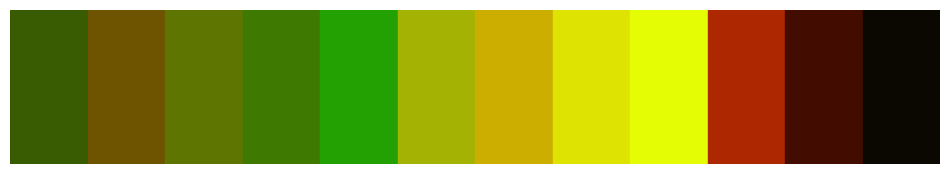

In [35]:
import numpy as np
from scipy.stats.qmc import Halton
from colorspacious import cspace_convert
import matplotlib.pyplot as plt
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000
import random

def generate_colors(num_colors, seed=0, hue_range=(0, 360), chroma_range=(0, 100), luminance_range=(0, 100), tolerance_threshold=2.0):
    """
    Parameters:
        num_colors (int): Number of colors to generate.
        seed (int): Seed for the Halton sequence generator.
        hue_range (tuple): Range of Hue values in degrees (0 to 360).
        chroma_range (tuple): Range of Chroma values.
        luminance_range (tuple): Range of Luminance values.
        tolerance_threshold (float): The ΔE*00 threshold for perceptual distinctness.
    
    Returns:
        rgb_colors (list): List of RGB colors in [R, G, B] format with values between 0 and 1.
    """
    # Initialize Halton sequence sampler
    sampler = Halton(d=3, scramble=True, seed=seed)
    samples = sampler.random(n=num_colors * 10)  # Generate more samples to account for gamut mapping

    # Scale samples to HCL ranges
    hues = samples[:, 0] * (hue_range[1] - hue_range[0]) + hue_range[0]
    chromas = samples[:, 1] * (chroma_range[1] - chroma_range[0]) + chroma_range[0]
    luminances = samples[:, 2] * (luminance_range[1] - luminance_range[0]) + luminance_range[0]

    # Combine HCL values
    hcl_colors = np.stack((hues, chromas, luminances), axis=1)

    rgb_colors = []
    count = 0
    index = 0

    valid_lab_colors = []  # To store valid Lab colors for ΔE* calculation
    while count < num_colors and index < len(hcl_colors):
        hcl = hcl_colors[index]
        index += 1

        # Convert HCL to Lab
        lab = hcl_to_lab(hcl)

        # Convert Lab to sRGB
        rgb = cspace_convert(lab, "CIELab", "sRGB1")

        # Check if RGB values are within the displayable gamut
        if np.all((rgb >= 0) & (rgb <= 1)):
            # Ensure that new color is perceptually distinct from existing colors
            distinct = True
            for existing_lab in valid_lab_colors:
                delta_e = delta_e_cie2000(LabColor(*existing_lab), LabColor(*lab))
                if delta_e < tolerance_threshold:
                    distinct = False
                    break

            if distinct:
                rgb_colors.append(rgb)
                valid_lab_colors.append(lab)
                count += 1

    if count < num_colors:
        print(f"Warning: Only {count} colors could be generated within the RGB gamut and tolerance constraints.")

    
    return rgb_colors

def hcl_to_lab(hcl):
    h, c, l = hcl
    h_rad = np.deg2rad(h)
    a = np.cos(h_rad) * c
    b = np.sin(h_rad) * c
    return np.array([l, a, b])


def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

def sort_by_perceptual_similarity(lab_colors):
    sorted_colors = [lab_colors[0]]
    remaining_colors = lab_colors[1:]

    while remaining_colors:
        last_color = sorted_colors[-1]
        # Find the color in remaining_colors closest to the last color in sorted_colors
        distances = [delta_e_cie2000(LabColor(*last_color), LabColor(*color)) for color in remaining_colors]
        closest_index = np.argmin(distances)
        sorted_colors.append(remaining_colors.pop(closest_index))

    return sorted_colors

def plot_colors(rgb_colors):
    n = len(rgb_colors)
    fig, ax = plt.subplots(figsize=(12, 2))
    
    for i, rgb in enumerate(rgb_colors):
        hex_code = rgb_to_hex(rgb)
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=rgb))
    
    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

if __name__ == "__main__":
    num_colors = 12
    seed = 887313999

    # User-defined HCL ranges
    hue_range = (0, 360)             # Full hue range
    chroma_range = (0, 80)          # Adjust based on desired colorfulness
    luminance_range = (0, 100)       # Avoid very dark or very light colors

    # Generate colors with a ΔE*00 tolerance threshold of 2.0
    colors = generate_colors(
        num_colors=num_colors,
        seed=seed,
        hue_range=hue_range,
        chroma_range=chroma_range,
        luminance_range=luminance_range,
        tolerance_threshold=2.0
    )
    
    # Convert the colors to Lab color space for perceptual ordering
    lab_colors = [cspace_convert(hcl_to_lab(hcl), "CIELab", "CIELab") for hcl in colors]
    sorted_lab_colors = sort_by_perceptual_similarity(lab_colors)
    
    plot_colors(sorted_lab_colors)

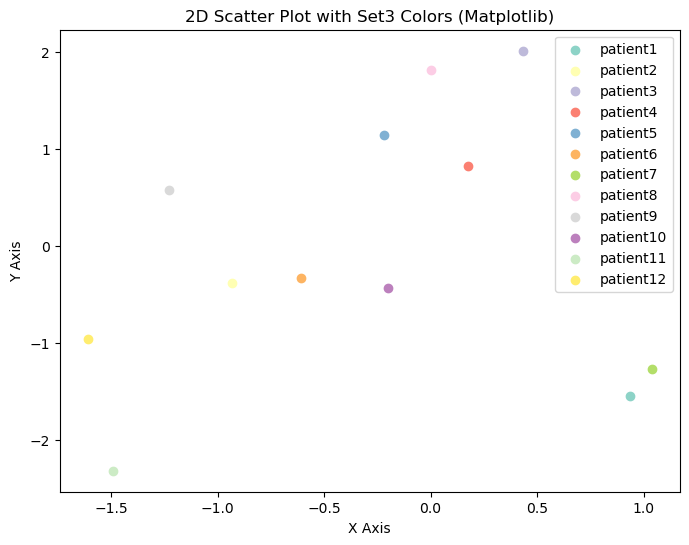

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
import pandas as pd

# Step 1: Define your 12 distinct colors from the Set3 palette
# You can use other palettes such as 'Paired', 'Dark2', or Plotly's 'Plotly'
colors_list = plt.get_cmap('Set3').colors[:12]  # First 12 colors from Set3
hex_colors = [mcolors.rgb2hex(c) for c in colors_list]

# Step 2: Map colors to patient IDs
ids_list = [f'patient{i}' for i in range(1, 13)]
patient_colors = {pid: hex_colors[i] for i, pid in enumerate(ids_list)}

# Example dataframe for plotting
df = pd.DataFrame({
    'x': np.random.randn(len(ids_list)),
    'y': np.random.randn(len(ids_list)),
    'z': np.random.randn(len(ids_list)),
    'patient_id': ids_list
})

# Step 3: Plot in Matplotlib
plt.figure(figsize=(8, 6))
for pid in ids_list:
    patient_data = df[df['patient_id'] == pid]
    plt.scatter(patient_data['x'], patient_data['y'], color=patient_colors[pid], label=pid)

plt.title("2D Scatter Plot with Set3 Colors (Matplotlib)")
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.legend()
plt.show()

# Step 4: Plot in Plotly (3D scatter)
fig = go.Figure()
for pid in ids_list:
    patient_data = df[df['patient_id'] == pid]
    fig.add_trace(go.Scatter3d(
        x=patient_data['x'],
        y=patient_data['y'],
        z=patient_data['z'],
        mode='markers',
        marker=dict(
            size=8,
            color=patient_colors[pid]  # Use the same mapped color
        ),
        name=pid
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
    ),
    title="3D Parameter Projection with Set3 Colors (Plotly)"
)

fig.show()


In [3]:
import numpy as np
from scipy.stats import uniform, norm

class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, dist='uniform', method='fixed', space='log10', dtype=np.float32):
        self.name = name
        self.dtype = dtype
        self.space = space
        self.l_lim = l_lim
        self.u_lim = u_lim
        self.dist = self._create_distribution(dist, l_lim, u_lim)
        self.val = self._convert_to_type(val if val is not None else self.sample_prior())
        self.method = method

    def _transform_bound(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _inverse_transform(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _create_distribution(self, dist, l_lim, u_lim):
        if self.space == 'log10':
            l_lim_transformed = np.log10(l_lim)
            u_lim_transformed = np.log10(u_lim)
        else:
            l_lim_transformed = l_lim
            u_lim_transformed = u_lim
        
        if dist == 'uniform':
            return uniform(loc=l_lim_transformed, scale=u_lim_transformed - l_lim_transformed)
        elif dist == 'normal':
            return norm(loc=(l_lim_transformed + u_lim_transformed) / 2, scale=(u_lim_transformed - l_lim_transformed) / 6)
        else:
            raise ValueError(f"Unsupported distribution type: {dist}")

    def _convert_to_type(self, value):
        return np.array(value, dtype=self.dtype).item()

    def sample_prior(self):
        sampled_value = self.dist.rvs()
        return self._convert_to_type(self._inverse_transform(sampled_value))

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        if self.space == 'log10':
            l_lim_transformed = np.log10(self.l_lim)
            u_lim_transformed = np.log10(self.u_lim)
            values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
            values = 10 ** values
        elif self.space == 'normal':
            values = np.linspace(self.l_lim, self.u_lim, num_points)
        else:
            raise ValueError(f"Unsupported space type: {self.space}")
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value
            self.reset_solutions()

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def sample_priors(self, force_sample=False):
        for name, param in self._parameters.items():
            if force_sample or param.method == 'sample':
                param.val = param.sample_prior()
        return {name: param for name, param in self._parameters.items()}

    def reset_solutions(self):
        if hasattr(self, 'patients'):
            for patient in self.patients.values():
                patient.sol = None
                patient.sse = None

    def compute_mean_parameters(self):
        for param_name, param_obj in self._parameters.items():
            values = [p.parameters._parameters[param_name].val for p in self.patients.values()]
            mean_val = np.mean(values)
            self._parameters[param_name].val = mean_val

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file.")

parameters = Parameters(
    E0=Parameter(name='E0', val=3.47E5, l_lim=1E4, u_lim=1E6, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E8, l_lim=1E8, u_lim=1E10, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'),
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-5, u_lim=1E-3, method='file', space='log10'),
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'),
    p=Parameter(name='p', val=0.05, l_lim=1E-3, u_lim=10, method='file', space='log10'),
    c=Parameter(name='c', val=13.934, l_lim=0.1, u_lim=1000, method='file', space='log10'),
    delta=Parameter(name='delta', val=0.96, l_lim=0.4, u_lim=10, method='file', space='log10'),
    xi=Parameter(name='xi', val=0.116467929, l_lim=1E-2, u_lim=1E1, method='fixed', space='log10'),
    a=Parameter(name='a', val=0.3615, l_lim=1E-2, u_lim=1E1, method='fixed', space='log10'),
    tau=Parameter(name='tau', val=1.38, l_lim=1E-1, u_lim=5, method='fit', space='log10'),
    d_E=Parameter(name='d_E', val=1.25, l_lim=1E-1, u_lim=1E2, method='fixed', space='log10'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-2, u_lim=100, method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=13019, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='log10', dtype=np.int8),
)

fit_parameters = [name for name, param in parameters._parameters.items() if param.method == 'fit'] or None
print(fit_parameters)


['tau']


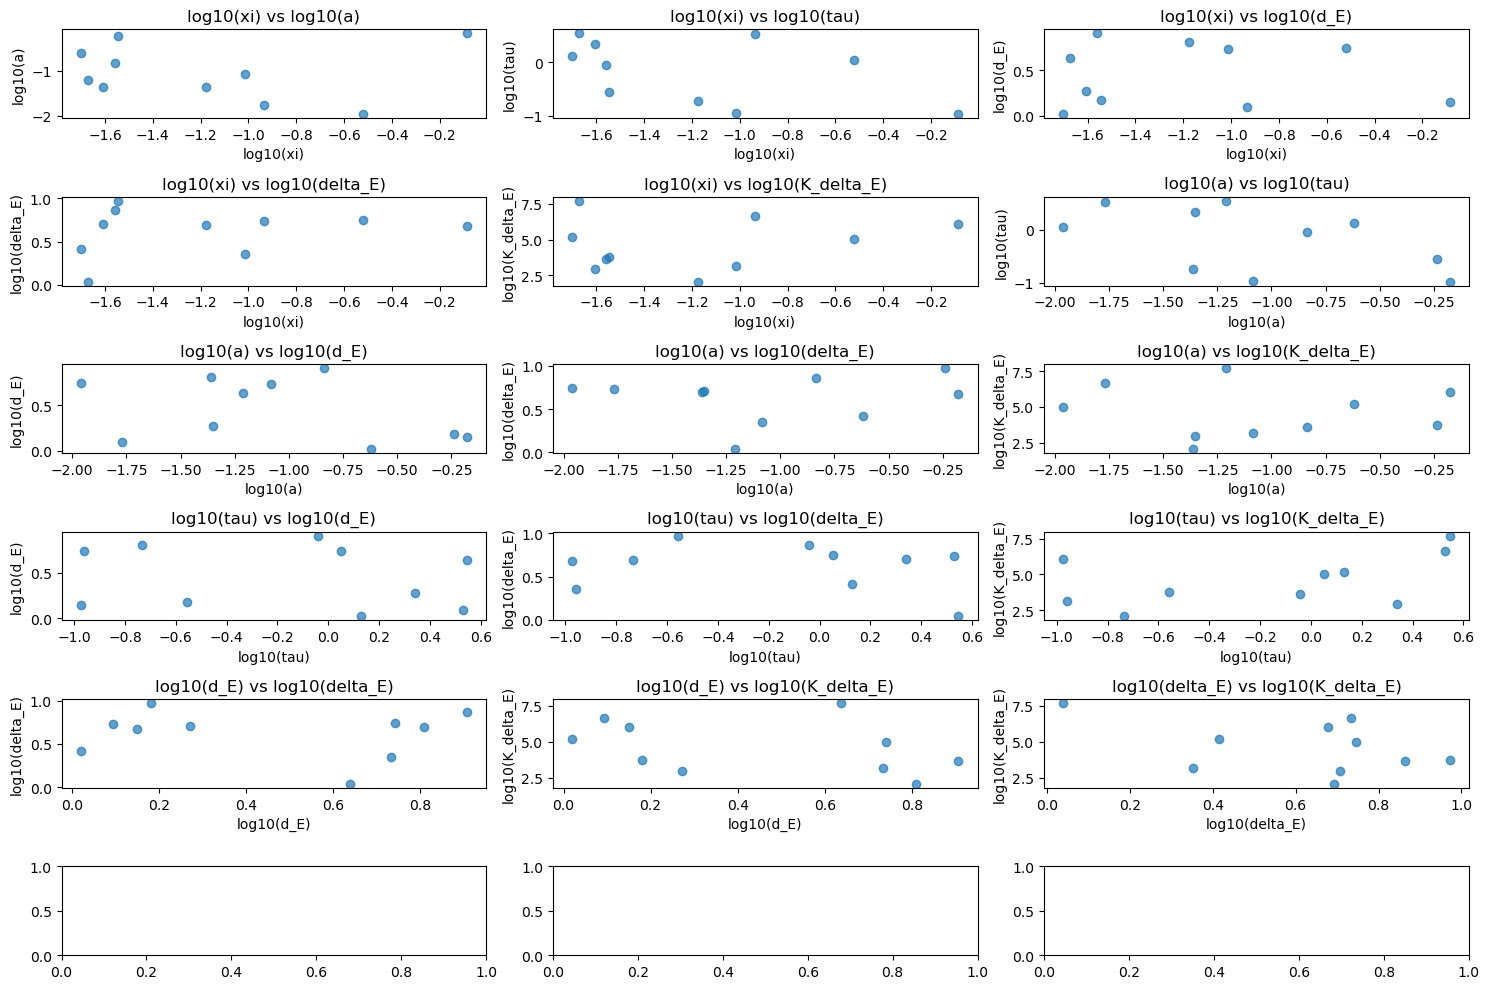


Pairwise Pearson Correlation (log space):
[[ 1.         -0.07572432 -0.45625664 -0.02557642  0.19585673  0.18686025]
 [-0.07572432  1.         -0.51212217 -0.36822276  0.10579569 -0.03995337]
 [-0.45625664 -0.51212217  1.         -0.16062855 -0.20923205  0.48669566]
 [-0.02557642 -0.36822276 -0.16062855  1.         -0.10825595 -0.35160184]
 [ 0.19585673  0.10579569 -0.20923205 -0.10825595  1.         -0.45571579]
 [ 0.18686025 -0.03995337  0.48669566 -0.35160184 -0.45571579  1.        ]]

Pairwise Distance Metrics (log space):
Min distance: 1.0849
Average distance: 2.7566
Max distance: 5.8401


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

param_bounds = {
    'xi': (0.01, 1),
    'a': (0.01, 1),
    'tau': (0.1, 4),
    'd_E': (1, 10),
    'delta_E': (1, 10),
    'K_delta_E': (1.00E+02, 1.00E+08)
}

# Function to sample in log space for given parameter bounds
def sample_parameters_in_log_space(param_names, n_samples):
    samples = {}
    
    for param in param_names:
        llim, ulim = param_bounds[param]
        # Convert bounds to log space
        log_llim = np.log10(llim)
        log_ulim = np.log10(ulim)
        # Sample uniformly in log space
        log_samples = np.random.uniform(log_llim, log_ulim, n_samples)
        # Convert back to natural space
        samples[param] = 10 ** log_samples

    return samples

# Function to visualize 2D scatter plots for all pairs of parameters
def visualize_parameter_scatter(samples):
    param_names = list(samples.keys())
    n_params = len(param_names)
    param_pairs = list(combinations(param_names, 2))  # Get all pairwise combinations of parameters

    fig, axs = plt.subplots(len(param_pairs) // 3 + 1, 3, figsize=(15, 10))
    axs = axs.flatten()

    for i, (param1, param2) in enumerate(param_pairs):
        axs[i].scatter(np.log10(samples[param1]), np.log10(samples[param2]), alpha=0.7)
        axs[i].set_xlabel(f'log10({param1})')
        axs[i].set_ylabel(f'log10({param2})')
        axs[i].set_title(f'log10({param1}) vs log10({param2})')

    plt.tight_layout()
    plt.show()

# Function to calculate pairwise distance metrics and correlation between parameters
def calculate_coverage_metrics(samples):
    param_names = list(samples.keys())
    
    # 1. Pairwise Pearson correlation between parameters in log space
    log_samples = np.array([np.log10(samples[param]) for param in param_names]).T
    corr_matrix = np.corrcoef(log_samples, rowvar=False)

    print("\nPairwise Pearson Correlation (log space):")
    print(corr_matrix)

    # 2. Pairwise distances in the full 6D space (log space)
    pairwise_distances = pdist(log_samples)  # Compute pairwise distances in 6D space
    distance_matrix = squareform(pairwise_distances)  # Convert to a square form matrix

    print("\nPairwise Distance Metrics (log space):")
    print(f"Min distance: {np.min(pairwise_distances):.4f}")
    print(f"Average distance: {np.mean(pairwise_distances):.4f}")
    print(f"Max distance: {np.max(pairwise_distances):.4f}")
    
    return corr_matrix, pairwise_distances

# Set up sampling
n_samples = 10  # Number of samples
param_names = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']  # List of parameters to sample

# Sample in log space
sampled_params = sample_parameters_in_log_space(param_names, n_samples)

# 2D scatter plots to visualize pairwise relationships
visualize_parameter_scatter(sampled_params)

# Numerical metrics to quantify coverage of the 6D space
corr_matrix, pairwise_distances = calculate_coverage_metrics(sampled_params)


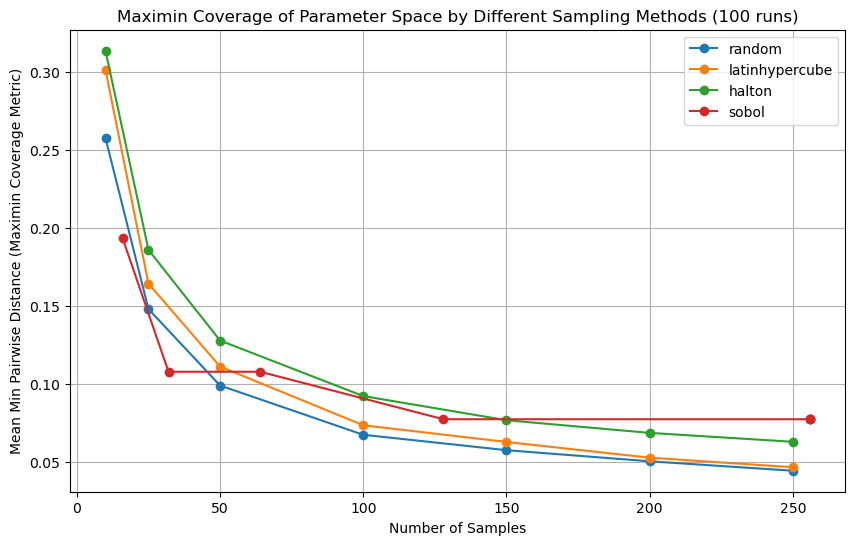

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.spatial.distance import pdist

# Define parameter bounds (natural space)
param_bounds = {
    'xi': (0.01, 1),
    'a': (0.01, 1),
    'tau': (0.1, 4),
    'd_E': (1, 10),
    'delta_E': (1, 10),
    'K_delta_E': (1.00E+02, 1.00E+08)
}

# Normalize the samples based on parameter bounds
def normalize_samples(samples, param_names):
    normalized_samples = []
    for i, param in enumerate(param_names):
        llim, ulim = param_bounds[param]
        # Normalize the samples to [0, 1]
        normalized_samples.append((samples[:, i] - llim) / (ulim - llim))
    return np.column_stack(normalized_samples)

# Helper function to convert samples to natural space from log space
def log_to_natural_space(samples, param_names):
    natural_samples = []
    for i, param in enumerate(param_names):
        llim, ulim = param_bounds[param]
        natural_samples.append(10 ** (samples[:, i] * (np.log10(ulim) - np.log10(llim)) + np.log10(llim)))
    return np.column_stack(natural_samples)

# Function to sample using different strategies
def sample_parameters(method, n_samples, param_names, pop_size=15, N_equal=0):
    dim = len(param_names)
    
    if method == 'random':
        # Random sampling in [0, 1] and then scale to log bounds
        samples = np.random.rand(n_samples, dim)
    
    elif method == 'latinhypercube':
        # Latin Hypercube Sampling (LHS)
        sampler = qmc.LatinHypercube(d=dim)
        samples = sampler.random(n=n_samples)
    
    elif method == 'halton':
        # Halton sequence
        sampler = qmc.Halton(d=dim)
        samples = sampler.random(n=n_samples)
    
    elif method == 'sobol':
        # Sobol sequence, sample size is determined by power of 2 within the given range
        n_samples = 2**int(np.ceil(np.log2(n_samples)))  # Sobol requires power of 2
        sampler = qmc.Sobol(d=dim, scramble=False)
        samples = sampler.random(n=n_samples)
    
    # Convert samples from [0,1] space to natural parameter space using log scale
    return log_to_natural_space(samples, param_names), n_samples

# Function to compute the Maximin criterion (maximize minimum pairwise distance)
def compute_maximin_coverage(samples):
    # Normalize samples before computing distances
    normalized_samples = normalize_samples(samples, param_names)
    pairwise_distances = pdist(normalized_samples, metric='euclidean')  # Euclidean distance
    return np.min(pairwise_distances)

# Function to evaluate each sampling method multiple times and return the mean Maximin coverage
def evaluate_sampling_methods(n_samples_list, param_names, n_repeats=100, pop_size=15, N_equal=0):
    methods = ['random', 'latinhypercube', 'halton', 'sobol']
    coverage_means = {method: [] for method in methods}
    actual_samples = {method: [] for method in methods}  # To store actual sample sizes for Sobol

    # Get all powers of 2 within the given range for Sobol sampling
    sobol_powers_of_2 = [2**i for i in range(int(np.floor(np.log2(min(n_samples_list)))), int(np.ceil(np.log2(max(n_samples_list)))) + 1)]
    
    for n_samples in n_samples_list:
        for method in methods:
            maximin_values = []
            actual_n_samples = n_samples

            if method == 'sobol':
                for sobol_samples in sobol_powers_of_2:
                    if sobol_samples >= n_samples:
                        actual_n_samples = sobol_samples
                        break
            
            for _ in range(n_repeats):
                samples, actual_n_samples = sample_parameters(method, actual_n_samples, param_names, pop_size, N_equal)
                maximin_metric = compute_maximin_coverage(samples)
                maximin_values.append(maximin_metric)
            
            coverage_means[method].append(np.mean(maximin_values))
            actual_samples[method].append(actual_n_samples)  # Record actual sample count
    
    return coverage_means, actual_samples

# Plotting the results
def plot_coverage_results(coverage_means, actual_samples, n_samples_list):
    plt.figure(figsize=(10, 6))
    
    for method, maximin_values in coverage_means.items():
        if method == 'sobol':
            plt.plot(actual_samples[method], maximin_values, label=method, marker='o')
        else:
            plt.plot(n_samples_list, maximin_values, label=method, marker='o')
    
    plt.xlabel("Number of Samples")
    plt.ylabel("Mean Min Pairwise Distance (Maximin Coverage Metric)")
    plt.title("Maximin Coverage of Parameter Space by Different Sampling Methods (100 runs)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the list of parameter names and the number of samples to test (up to 250 samples)
param_names = ['xi', 'a', 'tau', 'd_E', 'delta_E', 'K_delta_E']
n_samples_list = [10, 25, 50, 100, 150, 200, 250]

# Evaluate the sampling methods and plot the results (100 repetitions per method)
coverage_means, actual_samples = evaluate_sampling_methods(n_samples_list, param_names, n_repeats=100, pop_size=15, N_equal=0)
plot_coverage_results(coverage_means, actual_samples, n_samples_list)


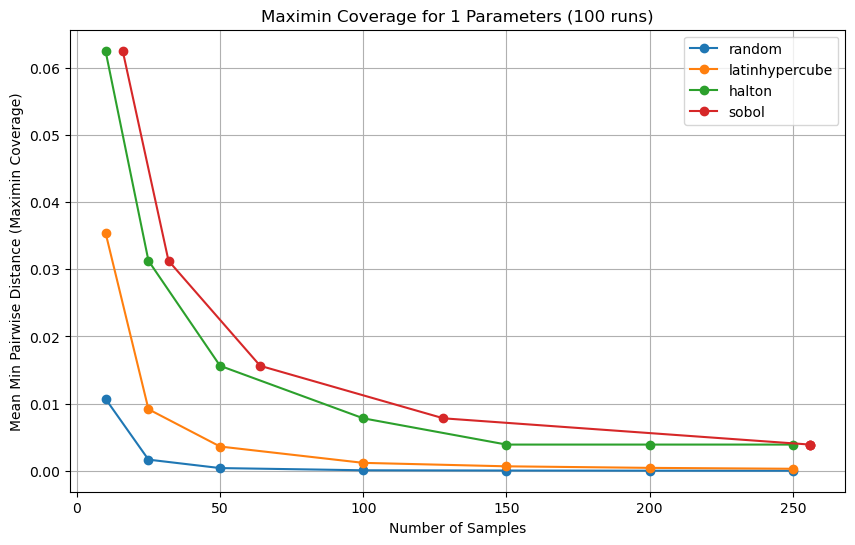

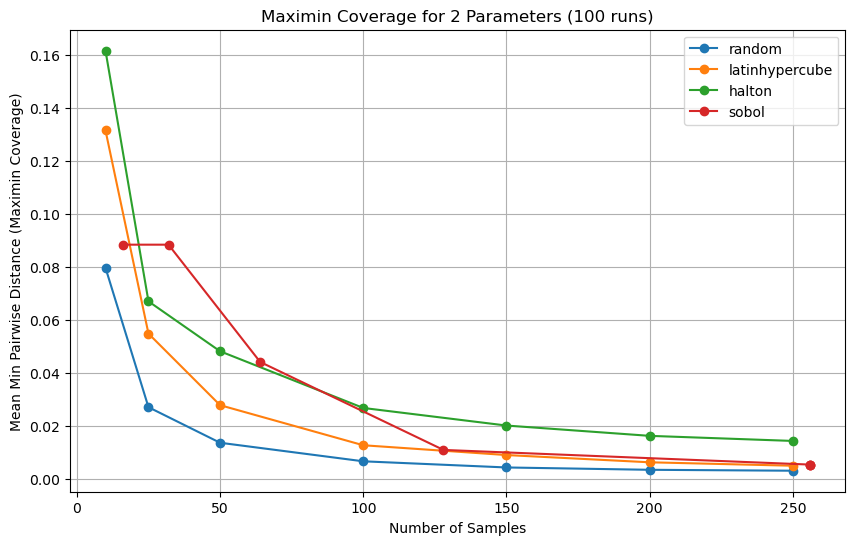

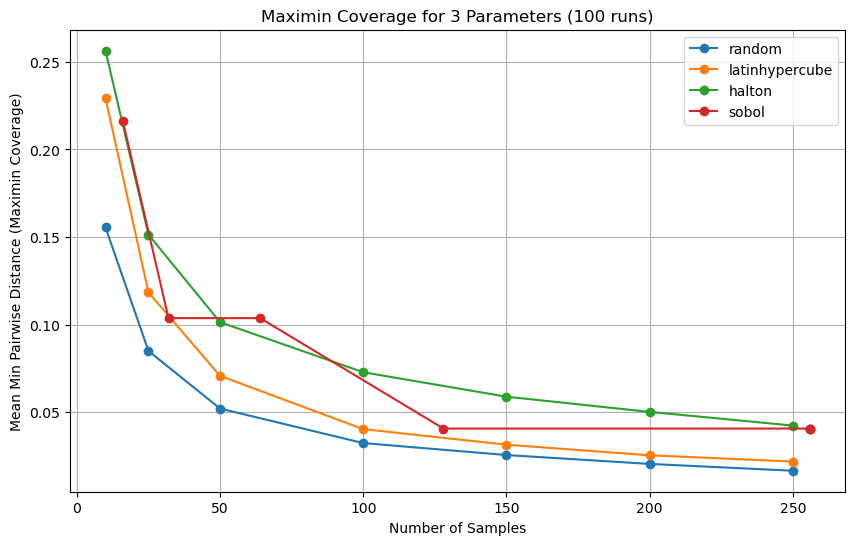

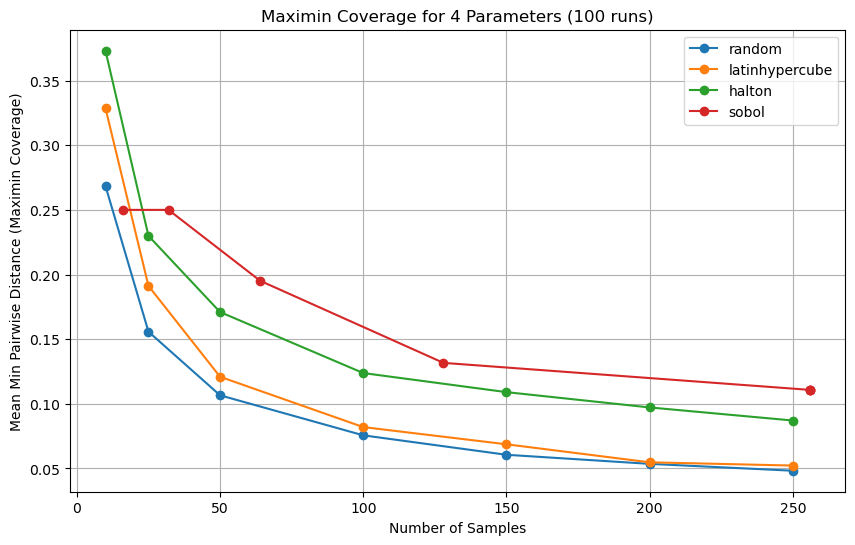

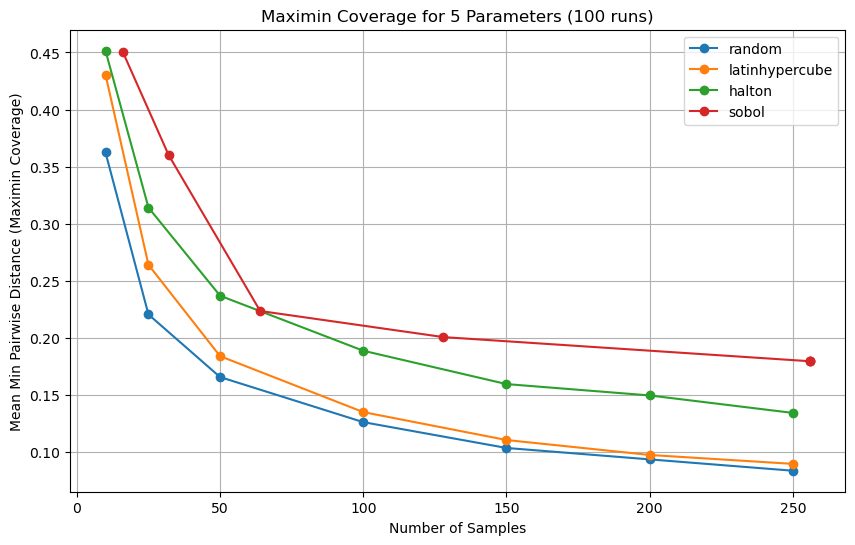

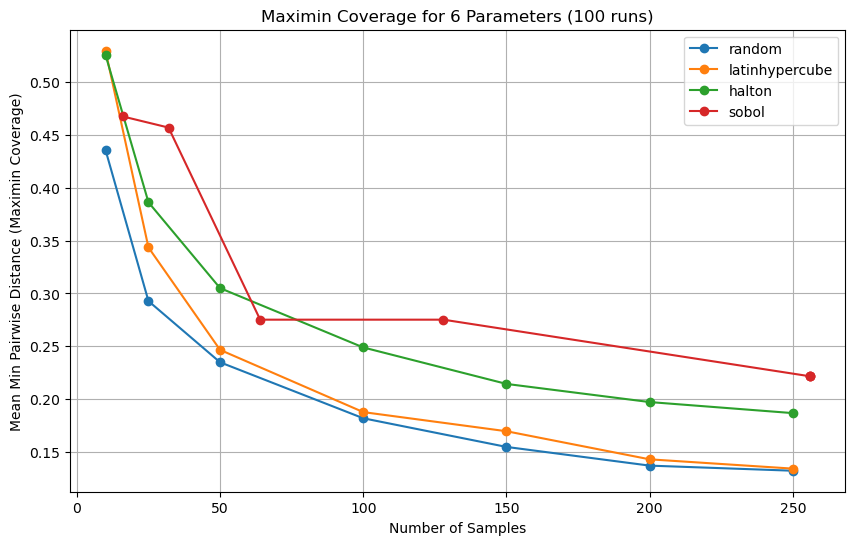

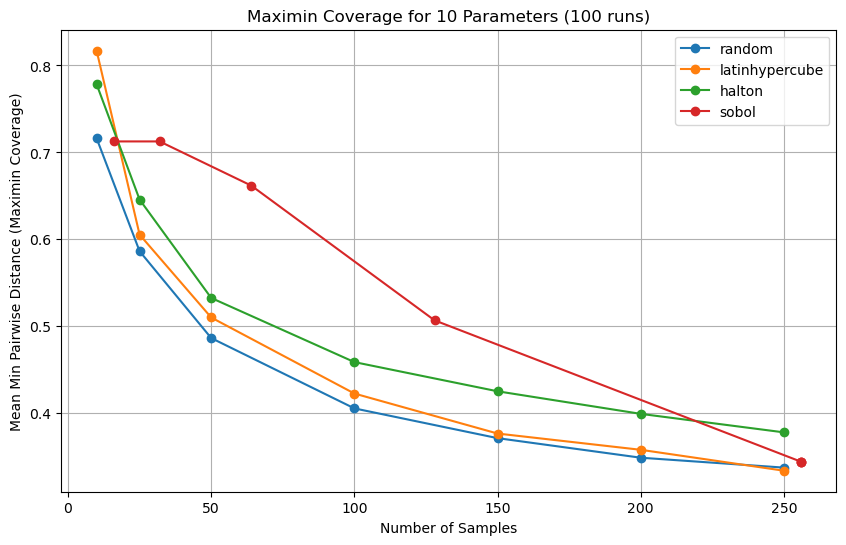

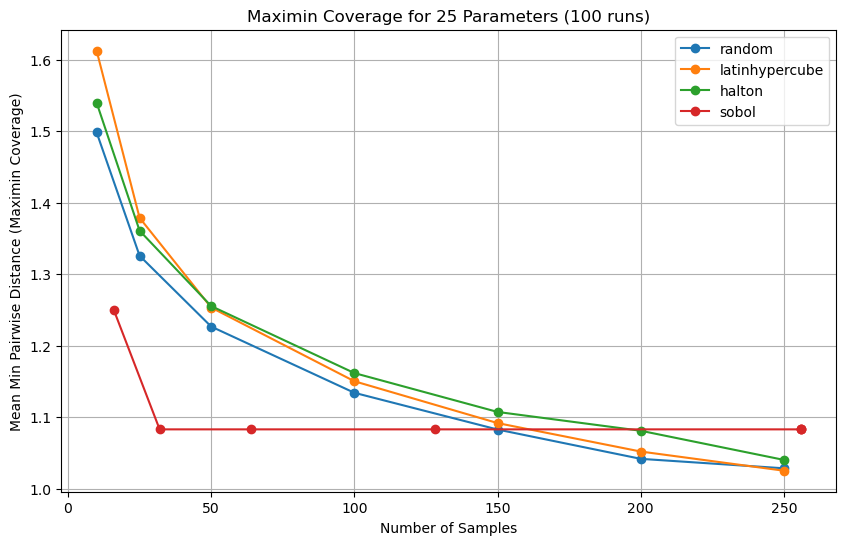

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.spatial.distance import pdist

# Function to sample using different strategies in [0,1]^x space
def sample_parameters_in_unit_cube(method, n_samples, n_params, pop_size=15, N_equal=0):
    if method == 'random':
        # Random sampling in [0, 1] space
        samples = np.random.rand(n_samples, n_params)
    
    elif method == 'latinhypercube':
        # Latin Hypercube Sampling (LHS)
        sampler = qmc.LatinHypercube(d=n_params)
        samples = sampler.random(n=n_samples)
    
    elif method == 'halton':
        # Halton sequence
        sampler = qmc.Halton(d=n_params)
        samples = sampler.random(n=n_samples)
    
    elif method == 'sobol':
        # Sobol sequence, sample size is determined by power of 2 within the given range
        n_samples = 2**int(np.ceil(np.log2(n_samples)))  # Sobol requires power of 2
        sampler = qmc.Sobol(d=n_params, scramble=False)
        samples = sampler.random(n=n_samples)
    
    return samples, n_samples

# Function to compute the Maximin criterion (maximize minimum pairwise distance)
def compute_maximin_coverage(samples):
    pairwise_distances = pdist(samples, metric='euclidean')  # Euclidean distance
    return np.min(pairwise_distances)

# Function to evaluate each sampling method multiple times and return the mean Maximin coverage
def evaluate_sampling_methods_with_params(n_samples_list, n_params_list, n_repeats=100, pop_size=15, N_equal=0):
    methods = ['random', 'latinhypercube', 'halton', 'sobol']
    results = {n_params: {method: [] for method in methods} for n_params in n_params_list}
    actual_samples = {n_params: {method: [] for method in methods} for n_params in n_params_list}

    for n_params in n_params_list:
        # Get all powers of 2 within the given range for Sobol sampling
        sobol_powers_of_2 = [2**i for i in range(int(np.floor(np.log2(min(n_samples_list)))), int(np.ceil(np.log2(max(n_samples_list)))) + 1)]

        for n_samples in n_samples_list:
            for method in methods:
                maximin_values = []
                actual_n_samples = n_samples

                if method == 'sobol':
                    for sobol_samples in sobol_powers_of_2:
                        if sobol_samples >= n_samples:
                            actual_n_samples = sobol_samples
                            break
                
                for _ in range(n_repeats):
                    samples, actual_n_samples = sample_parameters_in_unit_cube(method, actual_n_samples, n_params, pop_size, N_equal)
                    maximin_metric = compute_maximin_coverage(samples)
                    maximin_values.append(maximin_metric)
                
                results[n_params][method].append(np.mean(maximin_values))
                actual_samples[n_params][method].append(actual_n_samples)  # Record actual sample count
    
    return results, actual_samples

# Plotting the results for different parameter counts
def plot_coverage_results_across_params(results, actual_samples, n_samples_list, n_params_list):
    for n_params in n_params_list:
        plt.figure(figsize=(10, 6))
        
        for method, maximin_values in results[n_params].items():
            if method == 'sobol':
                plt.plot(actual_samples[n_params][method], maximin_values, label=method, marker='o')
            else:
                plt.plot(n_samples_list, maximin_values, label=method, marker='o')
        
        plt.xlabel("Number of Samples")
        plt.ylabel("Mean Min Pairwise Distance (Maximin Coverage)")
        plt.title(f"Maximin Coverage for {n_params} Parameters (100 runs)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Define the list of sample sizes and parameter counts
n_samples_list = [10, 25, 50, 100, 150, 200, 250]
n_params_list = [1, 2, 3, 4, 5, 6, 10, 25]

# Evaluate the sampling methods and plot the results for different parameter counts (100 repetitions per method)
results, actual_samples = evaluate_sampling_methods_with_params(n_samples_list, n_params_list, n_repeats=100, pop_size=15, N_equal=0)
plot_coverage_results_across_params(results, actual_samples, n_samples_list, n_params_list)
